- "등/하원때마다 성수역 앞의 따릉이가 쌓여있는것을 보고 따릉이를 필요한곳에 더, 반납이 많은곳엔 덜 배치해서 따릉이의 이용률을 더 높힐 수 있을까? 라는 의문점에서 출발.
- 대여소 번호가 많은 순으로 랭킹을 선정해서 수요가 가장 많았던 스테이션을 추려내고,반대로 반납 대여소를 카운트해서 가장 많았던 스테이션도 추려내서, 수요가 많은 곳에는 따릉이를 더 배치하고, 반납이 많았던 곳에는 따르이 배치를 덜 해서 효율성과 경제성을 도모 할 수 있는 인사이트 제시  "
- 코로나팬대믹 이후로 사람들은 따릉이를 더 탈까 덜 탈까?
- 재택근무의 확대로 유동자체가 적어져서 따릉이 이용 횟수가 적어졌을까? 아니면 팬대믹으로 대중교통 이용에 불안감이 조성되어 따릉이로 출퇴근을 해서 더 많아졌을까? 라는 궁금점에서 출발.
    - 7월과 8월의 비교
    - 19년도 7월과 20년도 7월의 이용량 비교 (코로나의 영향이 있는지)
    - 위 지표들간의 이용시간의 차이, 이용거리의 변화도 있는지 확인.

In [1]:
# 패키지 불러오기 
import pandas as pd
import numpy as np
from scipy.stats import mode
import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

import folium
from folium.plugins import MarkerCluster
import folium.features 

import warnings
warnings.filterwarnings(action='ignore')

plt.rc('font', family='AppleGothic') # 맥 OS 폰트 설정 
plt.rc('axes', unicode_minus=False)  # 마이너스 폰트 설정

#### 파일 불러오기

In [3]:
# 19년 7월 데이터 불러와서 합치기 
# 파일을 불러올 때 utf-8로 인코등 하려 했으나, 불가하여 cp949로 대체 
sb1907_1 = pd.read_csv('datas/seoul_share_bike_201907_1.csv', encoding='cp949')
sb1907_2 = pd.read_csv('datas/seoul_share_bike_201907_2.csv', encoding='cp949')
sb1907_3 = pd.read_csv('datas/seoul_share_bike_201907_3.csv', encoding='cp949')
    
sb1907 = pd.concat([sb1907_1, sb1907_2, sb1907_3])

# 19년 8월 데이터 불러와서 합치기
sb1908_1 = pd.read_csv('datas/seoul_share_bike_201908_1.csv', encoding='cp949')
sb1908_2 = pd.read_csv('datas/seoul_share_bike_201908_2.csv', encoding='cp949')
sb1908_3 = pd.read_csv('datas/seoul_share_bike_201908_3.csv', encoding='cp949')

sb1908 = pd.concat([sb1908_1, sb1908_2, sb1908_3])

# 20년 7월 8월 데이터는 같이 붙어 있던 데이털 먼저 분리 작업을하고 csv파일로 저장하였음.
# 20년 7월 데이터 불러오기 
sb2007 = pd.read_csv('datas/sb2007_01.csv')

# 20년 8월 데이터 불러오기 
sb2008 = pd.read_csv('datas/sb2008_01.csv')

In [4]:
# 대표로 19년 7월 데이터 확인
sb1907.head(3)

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간,이용거리
0,SPB-21789,2019-07-02 08:35:17,646,장한평역 1번출구 (국민은행앞),4,2019-07-02 08:42:31,3,중랑센터,2,6,1350.0
1,SPB-22363,2019-07-03 08:35:06,646,장한평역 1번출구 (국민은행앞),2,2019-07-03 08:42:28,3,중랑센터,2,7,1160.0
2,SPB-24965,2019-07-03 08:46:07,646,장한평역 1번출구 (국민은행앞),2,2019-07-03 09:09:44,3,중랑센터,14,23,1270.0


데이터들을 살펴보니 우리가 판단하기에 필요없는 컬럼들이 많고, 데이터 처리를 위해 컬럼명을 영어로 기재하는 것이 맞다고 판단했습니다.

해당 작업들을 진행했습니다.
- 자전거 대여현황 함수 설정
- 한글컬럼명(자전거번호, 대여일시, 대여_대여소번호, 대여_대여소명, 반납일시, 반납대여소번호, 반납대여소_이름, 이용시간, 이용거리)을 영문으로 변경
- 컬명중 '대여거치대'와 '반납거치대'는 필요없는 컬럼이라 판단, 제거하였습니다.
- 컬럼중 '대여일시', '반납일시'를 '날짜'와 '시간'으로 따로 분리 작업하였습니다.
- 자전거번호의 타입을 알기위해 앞에 'SPB'와 자전거 번호를 분리하여 자전거 번호만 남기는 작업을 진행하였습니다.
- 자전거번호만 남긴후 자전거 번호 타입을 1, 2, 3, 으로 분류작업하였습니다.
  - 자전거 번호 별 타입
    - 00001 ~ 10000 : 초기형 
    - 10001 ~ 20000 : 후기형
    - 20001 ~ 27000 : 개선형
    - 30001 ~       : QR단말기(뉴따릉이)형
    - 80001 ~       : 새싹따릉이 : 청소년, 어르신 등도 편리하게 이용할 수 있도록 만든 모델
  - 자전거 번호별 타입 지정 
    - 00001 ~ 27000 (초기형, 후기형, 개선형) -> 1
    - 30001 ~   (QR형) -> 2
    - 80001 ~   (새싹따릉이) ->3

#### 자전거 대여현황 함수로 설정하기 : 함수명 'using_change'
- 필요없는 column 제거 (drop)
  - 대여거치대
  - 반납거치대
- column명 영문으로 바꾸기 
  - 자전거 번호 -> bicycle_type
  - 대여일시 -> retal_dt
  - 대여_대여소번호 -> rental_station_num
  - 대여_대여소명 -> rental_station_name
  - 반납일시 -> return_dt
  - 반납대여소번호 -> return_station_num
  - 반납대여소_이름 -> return_station_name
  - 이용시간 -> using_time
  - 이용거리 -> using_distance

In [5]:
def using_change(df):
    df = df.drop(['대여거치대', '반납거치대'], axis=1) # 사용컬럼만 남기고 나미저 삭제
    df.columns=['bicycle_type','rental_dt','rental_station_num ','rental_station_name',
                'return_dt','return_station_num','return_station_name','using_time',
                'using_distance']  # 한글명 컬럼 -> 영문 컬럼으로 변경
    
    # rental_dt & return_dt를 split으로 날짜와 시간을 분리
    rent_D = df['rental_dt'].str.split(' ').str[0]    # 대여날짜 분리
    rent_T = df['rental_dt'].str.split(' ').str[1]    # 대여시간 분리 
    return_D = df['return_dt'].str.split(' ').str[0]  # 반납날짜 분리
    return_T = df['return_dt'].str.split(' ').str[1]  # 반납시간 분리
    
    # bicycle의 타입을 알기 위해 split으로 분리 후 번호만 저장
    bicycle_num = df['bicycle_type'].str.split('-').str[1]
    
    # 분리된 날짜와 시간 새로운 컬럼으로 삽입
    df['rental_day'] = rent_D            # 대여날짜
    df['rental_time'] = rent_T           # 대여시간
    df['return_day'] = return_D          # 반납날짜
    df['return_day'] = return_T          # 반납시간
    df['bicycle_type_num'] = bicycle_num     # 자잔거 타입 
    
    # 나누어진 기존의 컬럼 삭제(drop)
    df = df.drop('rental_dt', axis=1)       # 기존에 있었던 '대여일시(날짜, 시간이 같이 있는)' 컬럼 제거
    df = df.drop('return_dt', axis=1)       # 기존에 있었던 '반납일시(날짜, 시간이 같이 있는)' 컬럼 제거
    df = df.drop('bicycle_type', axis=1)    # 기존에 있었던 '자전거 번호(SPB-00000)' 컬럼 제거
    
    # 따릉이 번호에 따른 타입 분류 
    tmp = df['bicycle_type_num'].astype(int)  # 새로운 컬럼중 자전거 타입을 문자열에서 정수형 타입으로 변경
    df['bicycle_type_num'] = tmp              # 변경된 컬럼 다시 지정 
    
     # isin구문을 써서 열이 list 값들을 포함하고 있는 행들을 골라내고 자전거 타입에 따라 1, 2, 3, 4로 지정해주는 작업
    basic_bicycle = df[df['bicycle_type_num'].isin(range(0,27001))]  # (0번~27000번): 기본형, 후기형, 개선형 타입
    basic_bicycle['bicycle_type_num'] = 1  # '기본형', '후기형', '개선형'을 '1'번으로 지정
    qr_bicycle = df[df['bicycle_type_num'].isin(range(30000,80001))] # (30000번 ~ 80000번) : QR형
    qr_bicycle['bicycle_type_num'] = 2 # 'QR형'을 2번으로 지정
    kid_bicycle = df[df['bicycle_type_num'].isin(range(80001,200000))] # (80001번 ~ ) : 새싹따릉이(어린이와 노인들을 위한 자전거)
    kid_bicycle['bicycle_type_num'] = 3
    df = pd.concat([basic_bicycle, qr_bicycle, kid_bicycle]) # 지정한 자전거 타입을 하나로 합치기 
    
    # 빌린 날짜순 정렬
    df = df.sort_values(by='rental_day')
    
    # index reset
    df.reset_index(drop=True, inplace=True)
    
    return df

In [6]:
# 함수 적용해서 다시 변수 적용 
sb1907 = using_change(sb1907)
sb1908 = using_change(sb1908)
sb2007 = using_change(sb2007)
sb2008 = using_change(sb2008)

In [5]:
# 모든 row 데이터를 보기 위한 데이터 프레임 설정 
pd.set_option('display.max_rows', None)

In [6]:
# 19월 07월 08월 따로 파일 저장
sb1907.to_csv('datas/sb1907.csv', index=False)
sb1908.to_csv('datas/sb1908.csv', index=False)

In [7]:
# 20년 07월 08월 따로 파일 저장 
sb2007.to_csv('datas/sb2007.csv', index=False)
sb2008.to_csv('datas/sb2008.csv', index=False)

In [13]:
# 적용된 변수 다시 확인 
# 19년 07월 
sb1907.head(3)

,rental_station_num,rental_station_name,return_station_num,return_station_name,using_time,using_distance,rental_day,rental_time,return_day,bicycle_type_num
0,153,성산2교 사거리,934,신사동 성당,43,6160.0,2019-07-01,00:49:10,01:33:11,1
1,2373,개포동역 사거리,2246,서울시 품질시험소 앞,19,4540.0,2019-07-01,08:20:55,08:40:42,1
2,2255,시민의숲역 1번출구 옆,2246,서울시 품질시험소 앞,9,1550.0,2019-07-01,08:35:20,08:44:56,1


In [15]:
# 19년 08월 
sb1908.head(3)

,rental_station_num,rental_station_name,return_station_num,return_station_name,using_time,using_distance,rental_day,rental_time,return_day,bicycle_type_num
0,232,양평우림 이비즈센타 앞,1996,구일역 1번 출입구 앞,16,3970.0,2019-08-01,17:29:57,17:47:08,1
1,931,역촌파출소,933,LG서비스 역촌점,59,4500.0,2019-08-01,19:54:23,20:54:06,1
2,906,연신내역 5번출구150M 아래,933,LG서비스 역촌점,10,990.0,2019-08-01,21:08:20,21:18:55,1


In [17]:
# 20년 07월 
sb2007.head(3)

,rental_station_num,rental_station_name,return_station_num,return_station_name,using_time,using_distance,rental_day,rental_time,return_day,bicycle_type_num
0,610,동대문중 교차로,657,동대문롯데캐슬아파트 앞,3,450.00,2020-07-01,00:00:15,00:03:23,1
1,1210,롯데월드타워(잠실역2번출구 쪽),1263,장지공영차고지,37,5373.92,2020-07-01,18:42:32,19:19:21,2
2,1171,염창동 새마을금고 건너편 (모닝글로리),1169,염창역 1번 출구,8,690.19,2020-07-01,19:11:22,19:19:18,2


In [18]:
# 20년 8월 
sb2008.head(3)

,rental_station_num,rental_station_name,return_station_num,return_station_name,using_time,using_distance,rental_day,rental_time,return_day,bicycle_type_num
0,2294,두상빌딩 앞,2276,영동1교 (양재천근린공원),4,1110.0,2020-08-01,00:01:52,00:06:43,1
1,2621,한성백제역 2번 출구,2653,올림픽공원사거리(선수촌아파트),10,0.0,2020-08-01,10:00:51,10:11:09,2
2,2621,한성백제역 2번 출구,1211,방이삼거리,9,0.0,2020-08-01,10:01:55,10:11:05,2


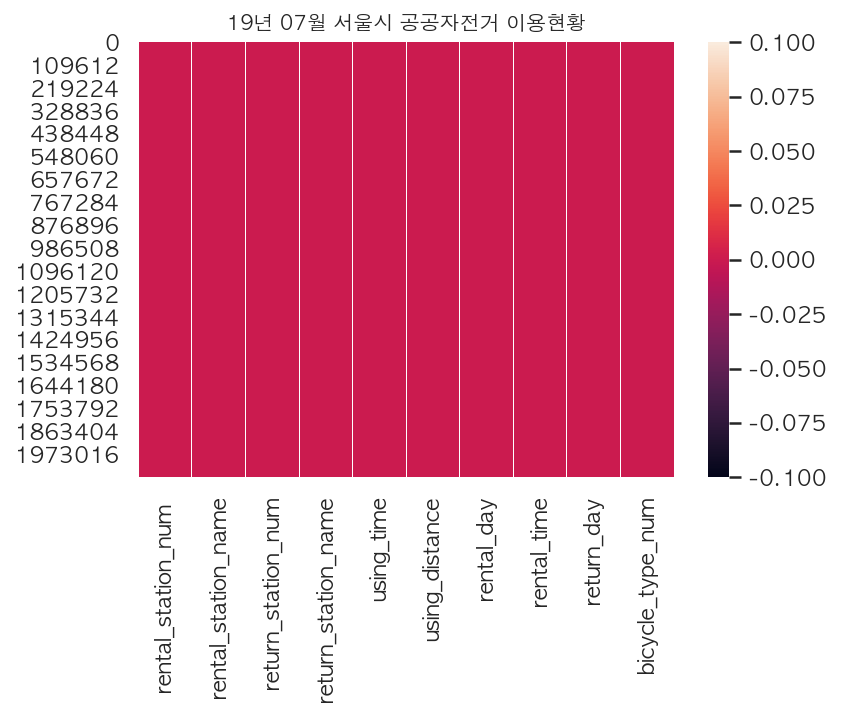

In [34]:
# 19년 07월 데이터 결측치 그래프로 확인 (시각화)
%matplotlib inline
sns.heatmap(sb1907.isnull(), cbar=True)
plt.title('19년 07월 서울시 공공자전거 이용현황', fontsize=10)
plt.show()

In [25]:
# 결측치 현황
sb1907.isna().sum()

rental_station_num     0
rental_station_name    0
return_station_num     0
return_station_name    0
using_time             0
using_distance         0
rental_day             0
rental_time            0
return_day             0
bicycle_type_num       0
dtype: int64

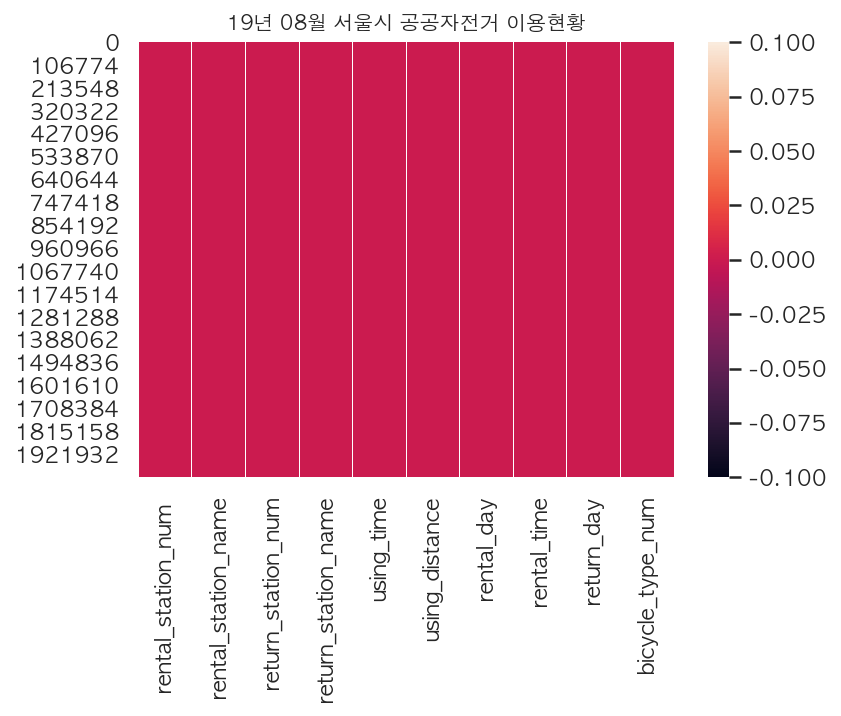

In [35]:
# 19년 08월 데이터 결측치 그래프로 확인 (시각화)
%matplotlib inline
sns.heatmap(sb1908.isnull(), cbar=True)
plt.title('19년 08월 서울시 공공자전거 이용현황', fontsize=10)
plt.show()

In [26]:
# 결측치 현황
sb1908.isna().sum()

rental_station_num     0
rental_station_name    0
return_station_num     0
return_station_name    0
using_time             0
using_distance         0
rental_day             0
rental_time            0
return_day             0
bicycle_type_num       0
dtype: int64

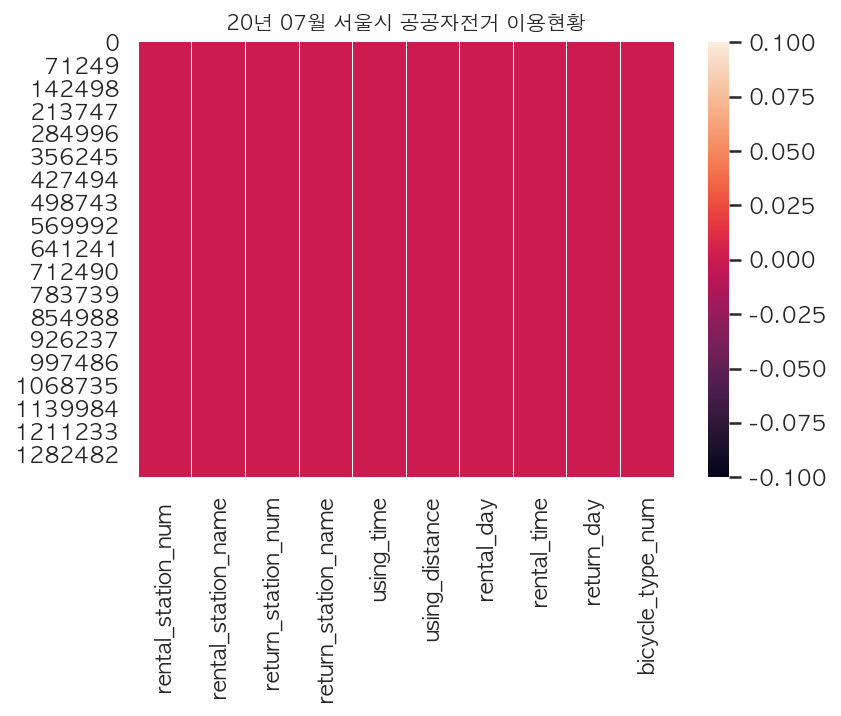

In [36]:
# 20년 07월 데이터 결측치 그래프로 확인 (시각화)
%matplotlib inline
sns.heatmap(sb2007.isnull(), cbar=True)
plt.title('20년 07월 서울시 공공자전거 이용현황', fontsize=10)
plt.show()

In [37]:
# 결측치 현황
sb2007.isna().sum()

rental_station_num     0
rental_station_name    0
return_station_num     0
return_station_name    0
using_time             0
using_distance         0
rental_day             0
rental_time            0
return_day             0
bicycle_type_num       0
dtype: int64

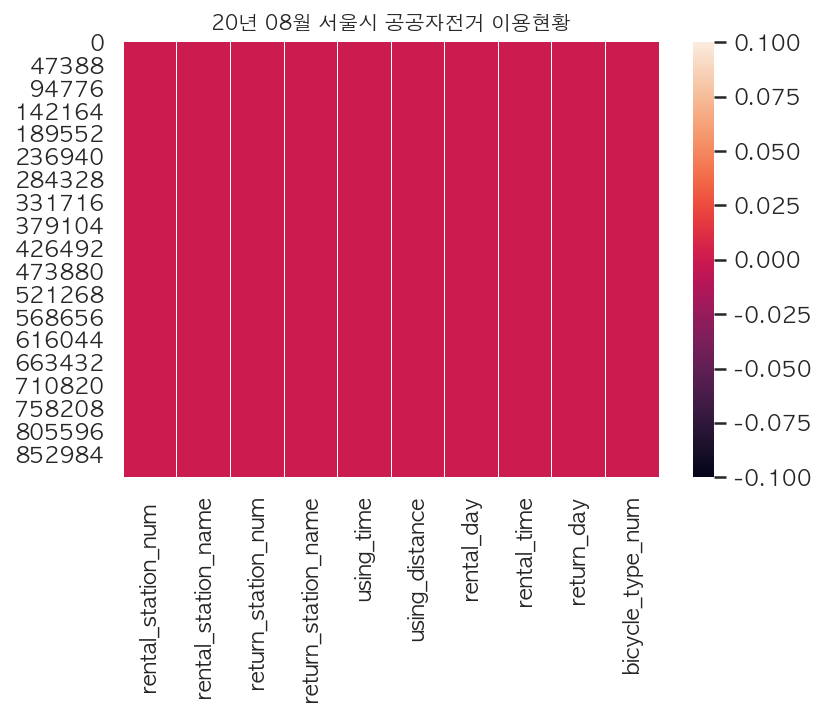

In [38]:
# 20년 08월 데이터 결측치 그래프로 확인 (시각화)
%matplotlib inline
sns.heatmap(sb2008.isnull(), cbar=True)
plt.title('20년 08월 서울시 공공자전거 이용현황', fontsize=10)
plt.show()

In [39]:
# 결측치 현황
sb2008.isna().sum()

rental_station_num     0
rental_station_name    0
return_station_num     0
return_station_name    0
using_time             0
using_distance         0
rental_day             0
rental_time            0
return_day             0
bicycle_type_num       0
dtype: int64

네 데이터 모두 결측치는 없습니다.

#### 자전거 스테이션 정보 불러오고, 데이터 정리하기

In [42]:
# 파일 불러오기 
st = pd.read_csv('datas/location_2021.csv', encoding='cp949')
st.head(3)

,대여소\n번호,보관소(대여소)명,소재지(위치),Unnamed: 3,Unnamed: 4,Unnamed: 5,설치\n시기,설치형태,Unnamed: 8,운영\n방식
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LCD,QR,NaN
1,NaN,NaN,자치구,상세주소,위도,경도,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,거치\n대수,거치\n대수,NaN


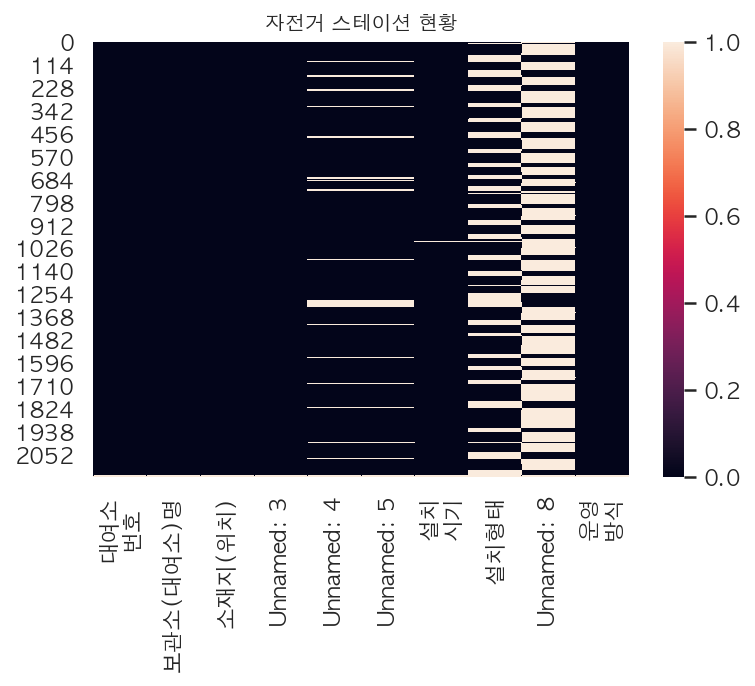

In [43]:
# 결측치 확인
%matplotlib inline
sns.heatmap(st.isnull(), cbar=True)
plt.title('자전거 스테이션 현황', fontsize=10)
plt.show()

또다른 파일인 스테이션 정보의 파일은 결칙치도 많고, 필요없는 컬럼이 많이 있어 정리가 필요하여, 해당 작업을 진행하였습니다.
- 컬럼에 '대여소번호', '보관소(대여소)명', '소재지', 'longitude(위도), 'latitude(경도)'을 모두 영문으로 바꿔주기 
- 필요없는 컬럼 '상세주소', '설치시기', '설치형태', '거치대수','운영방식'은 drop(삭제)하기 

In [45]:
# 사용할 컬럼만 선택하고 나머지는 drop하고 컬럼명 영문으로 바꿔줄 함수 설정 
def station_change(df):
    df = df.drop(['Unnamed: 3','설치\n시기','설치형태','Unnamed: 8','운영\n방식'],axis=1)
    df.columns=['station_num','station_name','location','longitude','latitude']
    return df

In [47]:
station = station_change(st)
station.head(3)

,station_num,station_name,location,longitude,latitude
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,자치구,위도,경도
2,NaN,NaN,NaN,NaN,NaN


In [49]:
# 결측치 제거 
station = station.dropna(axis=0)
station.head()

,station_num,station_name,location,longitude,latitude
4,301.0,경복궁역 7번출구 앞,종로구,37.575794,126.971451
5,302.0,경복궁역 4번출구 뒤,종로구,37.575947,126.974060
6,303.0,광화문역 1번출구 앞,종로구,37.571770,126.974663
7,304.0,광화문역 2번출구 앞,종로구,37.572113,126.977577
8,305.0,종로구청 옆,종로구,37.572582,126.978355


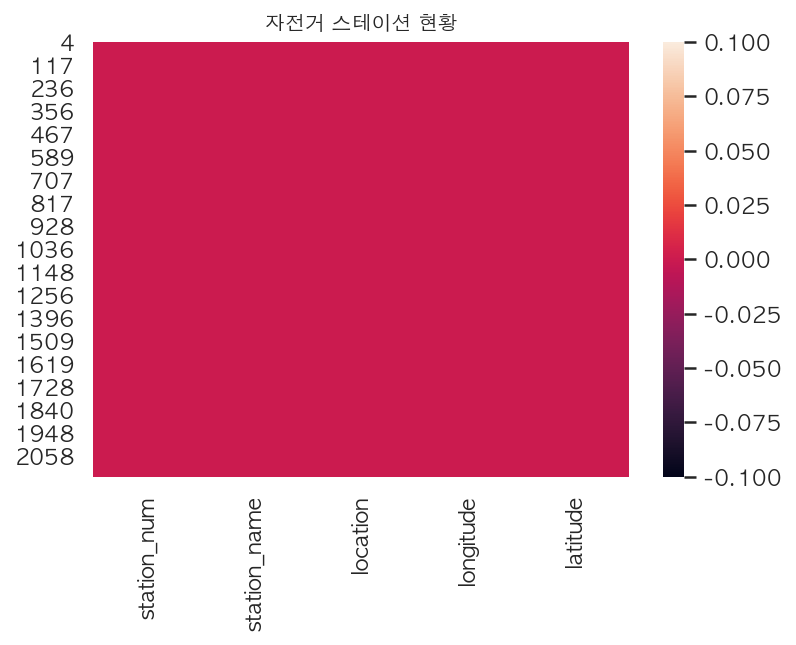

In [50]:
# 결측치 확인
%matplotlib inline
sns.heatmap(station.isnull(), cbar=True)
plt.title('자전거 스테이션 현황', fontsize=10)
plt.show()

In [ ]:
# 결측치 데이터까지 제거 완료된 스테이션 정보 CSV파일로 저장하기
station.to_csv('datas/station.csv', index=False)

In [52]:
station = pd.read_csv('datas/station.csv')
station.head()

,station_num,station_name,location,longitude,latitude
0,301.0,경복궁역 7번출구 앞,종로구,37.575794,126.971451
1,302.0,경복궁역 4번출구 뒤,종로구,37.575947,126.974060
2,303.0,광화문역 1번출구 앞,종로구,37.571770,126.974663
3,304.0,광화문역 2번출구 앞,종로구,37.572113,126.977577
4,305.0,종로구청 옆,종로구,37.572582,126.978355
